## 神经网络反向传播

### 神经网络学习的整个流程
主要有以下4个步骤：

- 前提：神经网络已经有合适的权重和偏置值。
- 选取输入数据：mini-batch从数据中随机选取一部分数据进行训练
- 计算梯度：计算各个权重参数的梯度
- 更新参数：将权重参数沿着梯度方向进行更新
- 重复上面的1-3步

这里我们使用误差反向传播的方案来进行梯度计算，可以大大提高学习的效率。

### 神经网络反向传播的实践

这里接着上一章节来学习，两层神经网络的实践，主要涉及到变量如下：
- params: 保存神经网络的参数的字典型变量
    - params['W1']  是第 1 层的权重，
    - params['b1']  是第 1 层的偏置。
    - params['W2']  是第 2 层的权重， 
    - params['b2']  是第 2层的偏置
- layers:保存神经网络的层的有序字典型变量。
    - 以  layers['Affine1'] 、 
    - layers['ReLu1'] 、
    - layers['Affine2']的形式，通过有序字典保存各个层
    
主要的方法：
- __init__(self, input_size, hidden_size, output_size, weight_init_std)进行初始化
- predict(self, x)进行识别
- loss(self, x, t) 计算损失函数的值。
- accuracy(self, x, t) 计算识别精度
- gradient(self, x, t) 通过误差反向传播法计算关于权重参数的梯度

下面coding 实现如下：


In [13]:
# softmax 函数的改进
import numpy as np
def softmax(a):
    c= np.max(a)
    b = a - c # 防止溢出
    exp_a = np.exp(b)
    sum_exp_a = np.sum(exp_a)
    y = exp_a/sum_exp_a
    return y

In [14]:
def cross_entropy_error(y,t):
    # 这里引入reshape变换
    #为了方便计算batch_size的输入
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+1e-7))/batch_size

In [11]:
# 批量数据Affine层的class
class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self,x):
        self.x = x
        out = np.dot(x,self.W) + self.b
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis=0)
        
        return dx

In [2]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)
        
    def backward(self,dout=1):
        #获取批量数据的大小
        batch_size = self.t.shape[0]
        # 需要平均化最后的结果
        dx = (self.y-self.t)/batch_size
        
        return dx

In [4]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self,x):
        # 将x中大于零的变为true,小于零变为False
        self.mask = (x <= 0)
        out = x.copy()
        #布尔类型索引,true的变为0
        out[self.mask] = 0 
        
        return out
    
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [15]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
#from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self,input_size,hidden_size,
                 output_size,weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
         # 生成层
        # 生成有序字典
        self.layers = OrderedDict()      
        self.layers['Affine1'] = Affine(
            self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(
            self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    # 预测/推理    
    def predict(self, x):
        # 循环执行每一层即可
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    #计算精度
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # 设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads
            

### 训练数据

接下来就是利用反向传播来对数据进行学习。

In [16]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

# 加载数据
(x_train,y_train),(x_test,y_test) = load_mnist(
                normalize=True,
                one_hot_label=True)

# 记录每次迭代的loss值
train_lost_list = []
train_acc_list = [] #记录训练精度
test_acc_list = [] #记录测试精度


#设置训练中参数
iters_num = 10000 # 训练次数
train_size = x_train.shape[0] #样本数量
batch_size = 100 #mini-batch的数量
learning_rate = 0.1 # 学习率

# 需要训练多次达到一个epoch
iter_per_epoch = max(train_size/batch_size,1)

#定义一个两层的网络
# 隐藏层为50
network = TwoLayerNet(input_size=784,
                     hidden_size=50,
                     output_size=10)

# 开始训练
for i in range(iters_num):
    # 随机选取输入的数据，选取的量为100个
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # 计算梯度
    grad = network.gradient(x_batch,y_batch)
    
    # 更新参数
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    #记录loss值
    loss = network.loss(x_batch,y_batch)
    train_lost_list.append(loss)
    
    if i%iter_per_epoch == 0:
        train_acc = network.accuracy(x_train,y_train)
        test_acc = network.accuracy(x_test,y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.19251666666666667, 0.1972
train acc, test acc | 0.09751666666666667, 0.0974
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.10218333333333333, 0.101


d:\program files\python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
d:\program files\python35\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
d:\program files\python35\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098


No handles with labels found to put in legend.


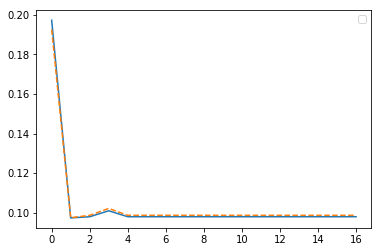

In [17]:
import  matplotlib.pyplot  as plt
%matplotlib inline

plt.plot(test_acc_list)
plt.plot(train_acc_list,linestyle="--")

plt.legend()
